In [ ]:
install.packages("recommenderlab", repos="https://cloud.r-project.org/")

In [ ]:
library(recommenderlab)
library(ggplot2)
library(dplyr)
library(data.table)
library(tibble)
library(tidyr)

## Load Datasets

In [3]:
books <- fread("books.csv")
head(books)

ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg
0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0399135782.01.LZZZZZZZ.jpg


In [4]:
ratings <- fread("ratings.csv")
head(ratings)

User-ID,ISBN,Book-Rating
<int>,<chr>,<int>
276725,034545104X,0
276726,0155061224,5
276727,0446520802,0
276729,052165615X,3
276729,0521795028,6
276733,2080674722,0


In [5]:
users <- fread("users.csv")
head(users)

User-ID,Location,Age
<int>,<chr>,<dbl>
1,"nyc, new york, usa",NA
2,"stockton, california, usa",18
3,"moscow, yukon territory, russia",NA
4,"porto, v.n.gaia, portugal",17
5,"farnborough, hants, united kingdom",NA
6,"santa monica, california, usa",61


## Data Preprocessing

In [6]:
books$isbn_numeric <- as.numeric(factor(books$ISBN))
ratings$isbn_numeric <- as.numeric(factor(ratings$ISBN, levels = books$ISBN))

In [7]:
# Count ratings per book
book_counts <- ratings %>% group_by(ISBN) %>% summarise(count = n())

# Filter books with at least 10 ratings
popular_books <- book_counts %>% filter(count >= 20)
filtered_ratings <- ratings %>% filter(ISBN %in% popular_books$ISBN)

filtered_ratings <- filtered_ratings %>% filter(!is.na(isbn_numeric))

# Count ratings per user
user_counts <- filtered_ratings %>% group_by(`User-ID`) %>% summarise(count = n())
active_users <- user_counts %>% filter(count >= 10)

filtered_ratings <- filtered_ratings %>% filter(`User-ID` %in% active_users$`User-ID`)

In [8]:
# Set up collaborative filtering
rating_matrix <- as(filtered_ratings %>% select(`User-ID`, isbn_numeric, `Book-Rating`), "realRatingMatrix")
dim(rating_matrix)

[1] 5767 7269

In [9]:
# Merge the 3 datasets using ISBN and User-ID
books <- books %>% select(ISBN, `Book-Title`, `Book-Author`, `Year-Of-Publication`, Publisher,`Image-URL-S`, `Image-URL-M`, `Image-URL-L`)
ratings <- ratings %>% select(`User-ID`, ISBN, `Book-Rating`)
users <- users %>% select(`User-ID`, Age)

ratings_books <- inner_join(ratings, books, by = "ISBN")
merged_data <- inner_join(ratings_books, users, by = "User-ID")
head(merged_data)

User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Age
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/034545104X.01.LZZZZZZZ.jpg,NA
276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0155061224.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0155061224.01.LZZZZZZZ.jpg,NA
276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0446520802.01.LZZZZZZZ.jpg,16
276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/052165615X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/052165615X.01.LZZZZZZZ.jpg,16
276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0521795028.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0521795028.01.LZZZZZZZ.jpg,16
276733,2080674722,0,Les Particules Elementaires,Michel Houellebecq,1998,Flammarion,http://images.amazon.com/images/P/2080674722.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2080674722.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2080674722.01.LZZZZZZZ.jpg,37


## Exploratory Data Analysis (EDA)

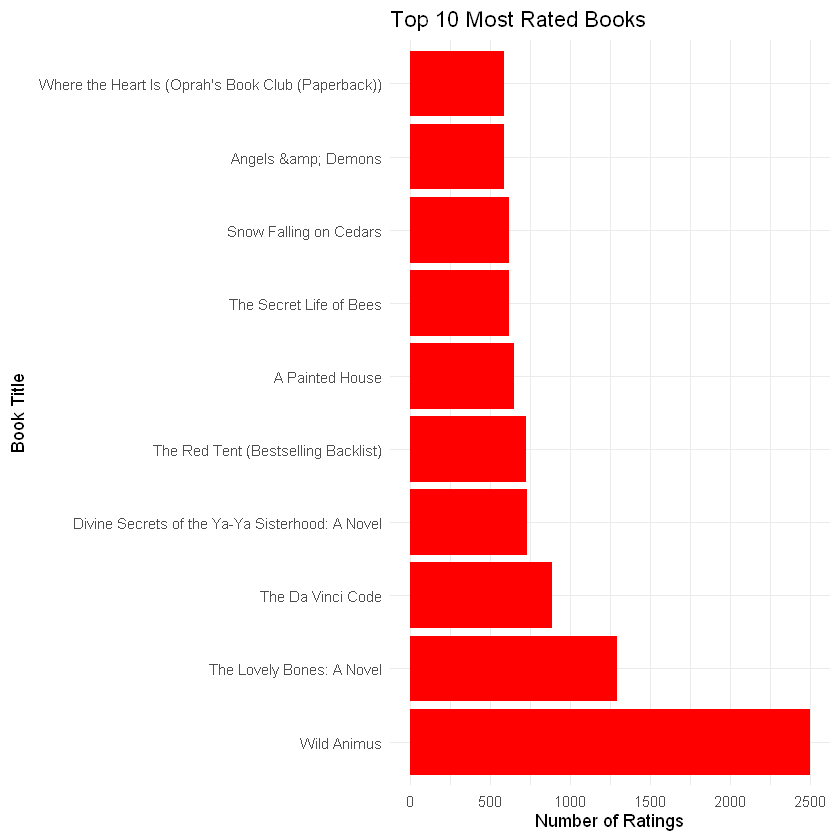

In [10]:
# Most rated books
top_books <- ratings %>%
  group_by(ISBN) %>%
  summarize(count = n()) %>%
  inner_join(books, by = "ISBN") %>%
  arrange(desc(count))

ggplot(top_books[1:10,], aes(x = reorder(`Book-Title`, -count), y = count)) +
  geom_bar(stat = "identity", fill = "red") +
  coord_flip() +
  labs(title = "Top 10 Most Rated Books", x = "Book Title", y = "Number of Ratings") +
  theme_minimal()

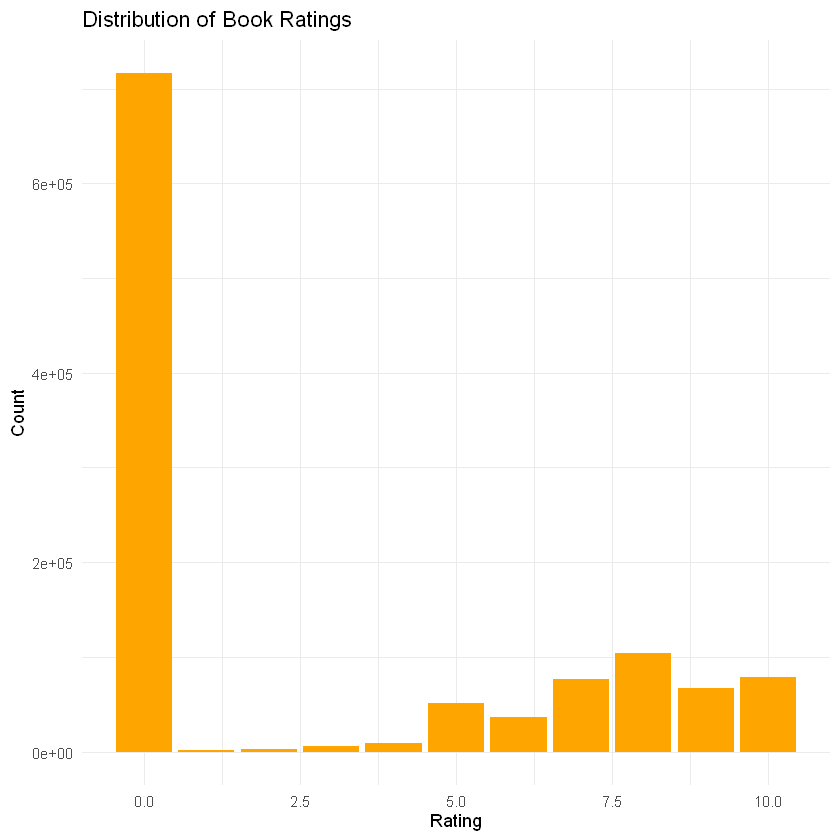

In [11]:
# Distribution of book ratings
ggplot(ratings, aes(x = `Book-Rating`)) +
  geom_bar(fill = "orange") +
  labs(title = "Distribution of Book Ratings", x = "Rating", y = "Count") +
  theme_minimal()

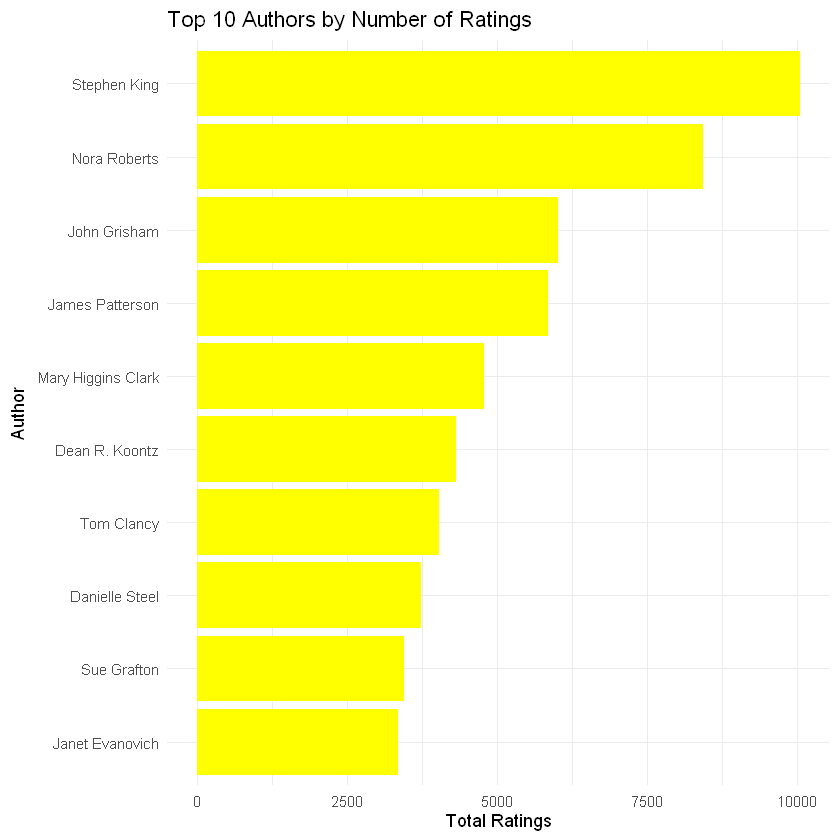

In [12]:
# Top authors by number of ratings
top_authors <- books %>%
  inner_join(ratings, by = "ISBN") %>%
  group_by(`Book-Author`) %>%
  summarise(total_ratings = n()) %>%
  arrange(desc(total_ratings)) %>%
  head(10)

ggplot(top_authors, aes(x = reorder(`Book-Author`, total_ratings), y = total_ratings)) +
  geom_bar(stat = "identity", fill = "yellow") +
  coord_flip() +
  labs(title = "Top 10 Authors by Number of Ratings", x = "Author", y = "Total Ratings") +
  theme_minimal()

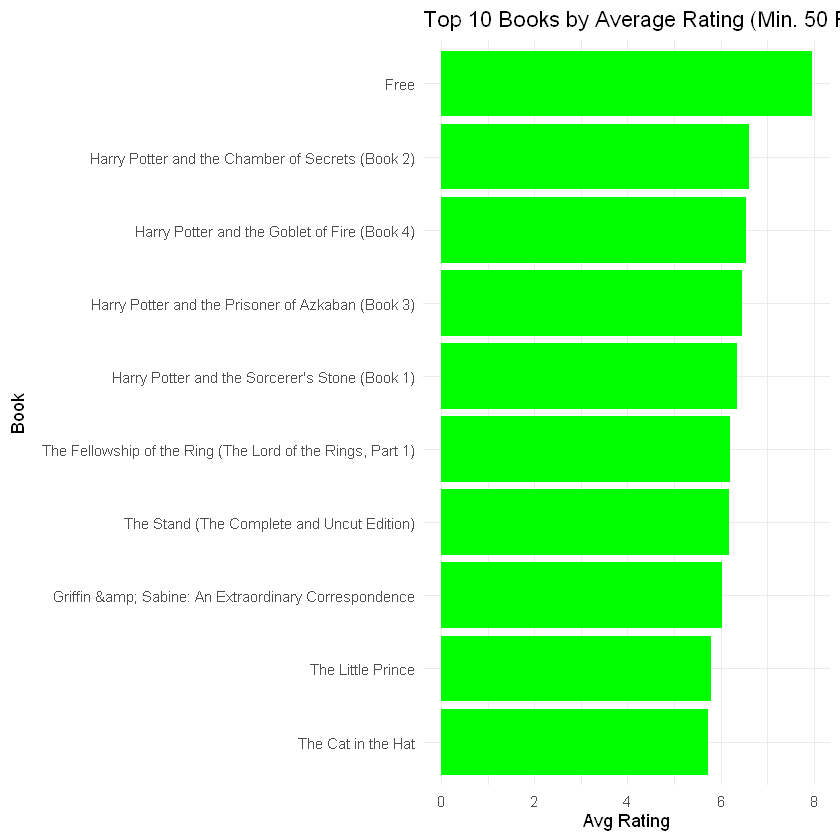

In [13]:
# Top books by averge rating
popular_books <- ratings %>%
  group_by(ISBN) %>%
  summarise(avg_rating = mean(`Book-Rating`), rating_count = n()) %>%
  filter(rating_count >= 50) %>%
  arrange(desc(avg_rating)) %>%
  inner_join(books, by = "ISBN") %>%
  select(`Book-Title`, `Book-Author`, avg_rating, rating_count) %>%
  head(10)

ggplot(popular_books, aes(x = reorder(`Book-Title`, avg_rating), y = avg_rating)) +
  geom_col(fill = "green") +
  coord_flip() +
  labs(title = "Top 10 Books by Average Rating (Min. 50 Ratings)", x = "Book", y = "Avg Rating") +
  theme_minimal()


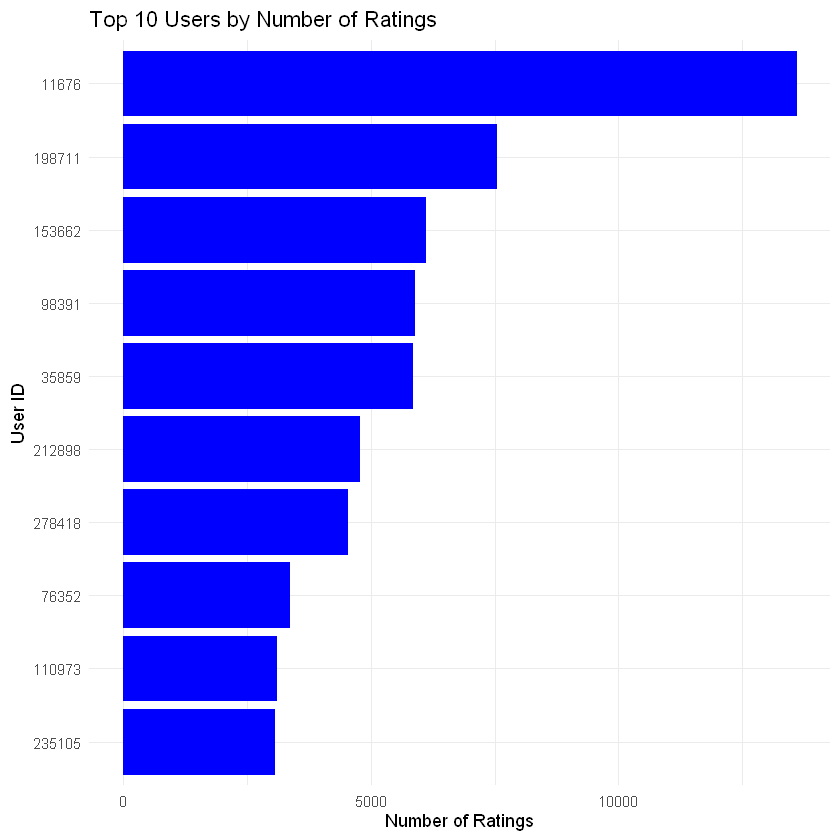

In [14]:
# Top users by number of ratings
top_users <- ratings %>%
  group_by(`User-ID`) %>%
  summarise(rating_count = n()) %>%
  arrange(desc(rating_count)) %>%
  head(10)

ggplot(top_users, aes(x = reorder(`User-ID`, rating_count), y = rating_count)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  labs(title = "Top 10 Users by Number of Ratings", x = "User ID", y = "Number of Ratings") +
  theme_minimal()


Warning message:
"Removed 110762 rows containing non-finite outside the scale range
(`stat_bin()`)."


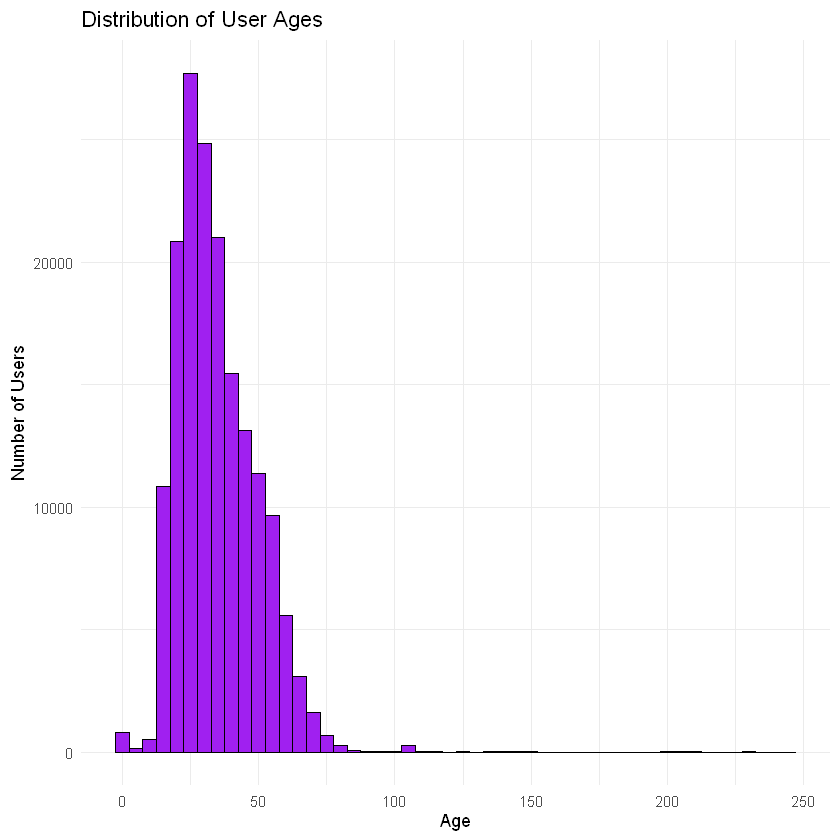

In [15]:
# Age distribution
ggplot(users, aes(x = Age)) +
  geom_histogram(binwidth = 5, fill = "purple", color = "black") +
  labs(title = "Distribution of User Ages", x = "Age", y = "Number of Users") +
  theme_minimal()

## Recommender System

In [16]:
# rating_matrix <- filtered_ratings %>%
#   select(`User-ID`, isbn_numeric, `Book-Rating`) %>%
#   pivot_wider(names_from = isbn_numeric, values_from = `Book-Rating`, values_fill = list(`Book-Rating` = NA))

# rownames(rating_matrix) <- rating_matrix$`User-ID`  
# rating_matrix$`User-ID` <- NULL

# rating_matrix <- as(as.matrix(rating_matrix), "realRatingMatrix")

In [17]:
# User-based collaborative filtering
recommender_model <- Recommender(rating_matrix, method = "UBCF")
print(recommender_model)

Recommender of type 'UBCF' for 'realRatingMatrix' 
learned using 5767 users.


## Make Predictions

In [18]:
# print(summary(colCounts(rating_matrix)))

In [22]:
user_id <- 2911

predictions <- predict(recommender_model, rating_matrix[user_id, ], n = 5, type = "topNList")
print(predictions)

recommended_books <- as(predictions, "list")[[1]]  # Extract recommendations

# Ensure ISBNs are characters for comparison
books$isbn_numeric <- as.character(books$isbn_numeric)
recommended_books <- as.character(recommended_books)

# Fetch recommended book details
recommended_books_df <- books %>%
  filter(isbn_numeric %in% recommended_books) %>%
  select(`Book-Title`, `Book-Author`, Publisher)

print(recommended_books_df)

Recommendations as 'topNList' with n = 5 for 1 users. 
Empty data.table (0 rows and 3 cols): Book-Title,Book-Author,Publisher


## Evaluation

In [20]:
set.seed(123)
train_index <- sample(seq_len(nrow(ratings)), size = 0.8 * nrow(ratings))
train_data <- ratings[train_index, ]
test_data <- ratings[-train_index, ]

test_data <- test_data %>%
  filter(ISBN %in% train_data$ISBN)

test_data$`User-ID` <- as.factor(test_data$`User-ID`)
test_data$isbn_numeric <- as.numeric(factor(test_data$ISBN, levels = unique(train_data$ISBN)))

In [ ]:
test_predictions <- predict(recommender_model, rating_matrix[user_id, ], type = "ratings")

In [ ]:
test_matrix <- as(test_data %>% select(`User-ID`, isbn_numeric, `Book-Rating`), "realRatingMatrix")

In [ ]:
actual_ratings <- as.numeric(as(test_matrix, "matrix"))
predicted_ratings <- as.numeric(as(test_predictions, "matrix"))

### RMSE

In [ ]:
rmse <- function(actual, predicted) {
  sqrt(mean((actual - predicted) ^ 2))
}

rmse_value <- rmse(actual_ratings, predicted_ratings)
rmse_value

### MAE

In [ ]:
mae <- function(actual, predicted) {
  mean(abs(actual - predicted))
}

mae_value <- mae(actual_ratings, predicted_ratings)
mae_value

### Hit Rate

In [ ]:
hit_rate <- function(predictions, actual, top_n = 5) {
  hits <- 0
  total_users <- length(actual)

  for (i in seq_len(total_users)) {
    if (actual[i] %in% predictions[[i]][1:top_n]) {
      hits <- hits + 1
    }
  }

  return(hits / total_users)
}

test_top_n <- predict(recommender_model, test_matrix, n = 5, type = "topNList")
hit_rate_value <- hit_rate(as(test_top_n, "list"), actual_ratings, top_n = 5)
hit_rate_value